<h1>Computer Vision Project</h1>
<h2>Phase 1</h2>
<h3>Team 3</h3>
<ul><li>Anas Salah</li>
<li> Alaa Hamdy </li>
<li>Ahmed Amr </li>
</ul>

<h3>Import libraries and packages used</h3>

In [2]:
import os
import numpy as np
import pandas as pd
from collections import Counter
import cv2
import imutils
import json
import statistics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torch import nn
from torchvision import ops
from operator import itemgetter



<h3>Load training images</h3>

In [3]:
images = []
labels = []
true_boxes = []

picsFolder_path = "train/train/"
with open('digitStruct.json') as f:
    data = json.load(f)

# import colored pictures
for i in range(len(data)):
    image = cv2.imread(picsFolder_path + data[i]['filename'])
    images.append(image)
    temp=[]
    for j in range(len(data[i]['boxes'])):
        temp.append(data[i]['boxes'][j]['label'])
    temp = np.array(temp)
    labels.append(temp)
    true_boxes.append(data[i]['boxes'])

# for image in os.listdir(picsFolder_path):
#     images.append(image)
print("we have",len(images),"images")



we have 33402 images


<h3>Resizing Images</h3>

In [4]:
resizedImages =[]
for image in images:
    resizedImages.append(cv2.resize(image,(100,75)))


<h3> Creating Images Copy</h3>

In [5]:
imagesCopy = []
for resizedimage in resizedImages:
    imagesCopy.append(resizedimage)
# print(len(imagesCopy))

<h3>Converting Original Images copy from BGR to Grayscale  </h3>

In [6]:
greyImages = [] 
# Convert BGR to grayscale:
for resizedimage in resizedImages:
    greyImages.append(cv2.cvtColor(resizedimage, cv2.COLOR_BGR2GRAY)) 

<h3>Adaptive Thresholding on Grayscale Images</h3>

In [7]:
# Set the adaptive thresholding:
windowSize = 31
windowConstant = -1

binaryImages = []


# Apply the threshold:
for greyimage in greyImages:
    binaryImages.append(cv2.adaptiveThreshold(greyimage, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,
                                        windowSize, windowConstant))

<h3>Perform Connected Components on the Binary Images</h3>

In [8]:
filteredImages =[]

# Perform Connected Components:
for binaryimage in binaryImages:
    componentsNumber, labeledImage, componentStats, componentCentroids = cv2.connectedComponentsWithStats(binaryimage,
                                                                                                          connectivity=4)
    # Set the minimum pixels for the area filter to filter connected components:
    minArea = 20

    # Get the indices/labels of the remaining components based on the area stat
    # (skip the background component at index 0)
    remainingComponentLabels = [i for i in range(1, componentsNumber) if componentStats[i][4] >= minArea]
    # Filter the labeled pixels based on the remaining labels,
    # assign pixel intensity to 255 (uint8) for the remaining pixels
    # y3ni b3d de el mafood yfdal the largest connected components that hopefully contains the digits
    # one problem is that background connected components may still exist
    filteredImages.append(np.where(np.isin(labeledImage, remainingComponentLabels) == True, 255, 0).astype('uint8'))


<h3>Morphological Operations - Closing on Filtered Images</h3>

In [9]:
# Set kernel (structuring element) size:
kernelSize = 3

# Set operation iterations:
opIterations = 1

# Get the structuring element:
maxKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernelSize, kernelSize))

closingImages = []

# Perform closing:
for filteredimage in filteredImages:
    closingImages.append(cv2.morphologyEx(filteredimage, cv2.MORPH_CLOSE, maxKernel, None, None, opIterations,
                                cv2.BORDER_REFLECT101))


<h3>Opening on the Closed Images (not used) </h3>

In [10]:
# Set kernel (structuring element) size:
kernelSize = 3

# Set operation iterations:
opIterations = 1

# Get the structuring element:
maxKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernelSize, kernelSize))

openingImages = []

# Perform closing:
for closingimage in closingImages:
    openingImages.append(cv2.morphologyEx(closingimage, cv2.MORPH_CLOSE, maxKernel, None, None, opIterations,
                                cv2.BORDER_REFLECT101))

<h3>Gaussian Blur on Opened Images(not used)</h3>

In [11]:
smoothedImages =[]

# perform smoothing
for closingimage in closingImages:
    smoothedImages.append(cv2.GaussianBlur(closingimage, (3, 3), 0))

<h3>Canny Edge Detection on Smoothed Images </h3>

In [12]:
edgeImages =[]

# perform smoothing
for closingimage in closingImages:
# perform canny edge detection:
    edgeImages.append(cv2.Canny(closingimage, 100, 200))

<h3> Drawing bounding boxes on digits </h3>

In [13]:
# index = 0
# Get each bounding box
# Find the big contours on the filtered image:
# for edgeimage in edgeImages:
def draw_boxes(edgeimage, copyimage):
    contours, hierarchy = cv2.findContours(edgeimage, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    contours_poly = [None] * len(contours)
    # The Bounding Rectangles will be stored here:
    boundRect = []
    # Alright, just look for the outer bounding boxes:
    for i, c in enumerate(contours):
        if hierarchy[0][i][3] == -1:
            contours_poly[i] = cv2.approxPolyDP(c, 3, True)
            boundRect.append(cv2.boundingRect(contours_poly[i]))
    for i in range(len(boundRect)):

        color = (0, 255, 0)
        # filter contours according to the area of the rectangle (parameter re5em)
        if ( int(boundRect[i][2])*int(boundRect[i][3])>100 and int(boundRect[i][2])*int(boundRect[i][3])<1000):
            cv2.rectangle(copyimage, (int(boundRect[i][0]), int(boundRect[i][1])),
                          (int(boundRect[i][0] + boundRect[i][2]), int(boundRect[i][1] + boundRect[i][3])), color, 2)
    # index= index + 1
    boxes= []
            # Iterate through each bounding box
    for i in range(len(boundRect)):
        # Extract the coordinates and dimensions of the bounding box
        x, y, w, h = boundRect[i]
            
        # Append the bounding box to the list in the format of a dictionary
        boxes.append({'left': x, 'top': y, 'width': w, 'height': h})
        
    # Return the list of bounding boxes
    return boxes    




<h3>Accuracy Functions </h3>

In [14]:
def box_iou(boxA, boxB):
    # Calculate the intersection coordinates of the two bounding boxes
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    
    # Compute the area of intersection rectangle
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    
    # Compute the area of both bounding boxes
    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    # Compute the union area
    union_area = boxA_area + boxB_area - intersection_area
    
    # Compute the IOU
    iou = intersection_area / union_area
    
    return iou


In [15]:

def iouPicTest(truth, predicted, threshold1=0.5):
    ious = []
    for i in range(len(truth)):
        for j in range(len(predicted)):
            truth_box = [truth[i]['left'], truth[i]['top'], truth[i]['left'] + truth[i]['width'], truth[i]['top']+truth[i]['height']]
            predicted_box = [predicted[j]['left'], predicted[j]['top'], predicted[j]['left']+predicted[j]['width'], predicted[j]['top']+predicted[j]['height']]
            iou = box_iou(truth_box, predicted_box)
            if iou >= threshold1:
                ious.append(iou)
    acc = np.average(ious) if ious else 0
    return acc



In [16]:
def overlapTest(truth, predicted, threshold=0.7):
    tp = 0
    fp = 0
    for i in range(len(predicted)):
        matched = False
        for j in range(len(truth)):
            truth_box = [truth[j]['left'], truth[j]['top'], truth[j]['left'] + truth[j]['width'], truth[j]['top'] + truth[j]['height']]
            predicted_box = [predicted[i]['left'], predicted[i]['top'], predicted[i]['left'] + predicted[i]['width'], predicted[i]['top'] + predicted[i]['height']]
            iou = box_iou(truth_box, predicted_box)
            if iou >= threshold:
                matched = True
                break
        if matched:
            tp += 1
        else:
            fp += 1
    if len(truth) > 0:
        fn = len(truth) - tp
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_score = 2 * precision * recall / (precision + recall)
        return tp,precision, recall, f1_score
    else:
        return 0, 0, 0

<h2>Algorithm 2 </h2>

In [19]:
def finalModel(image):
    
    boxes = []

    #convert the image to greyscale
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    

    #increase the contrast
    cv2.convertScaleAbs(image, image)
   

    #apply gaussian blur to smooth the image
    image = cv2.GaussianBlur(image, (3, 3), 0)
    

    #apply adaptive threshholding
    image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,1)
 


    #apply canny edge detection
    image = cv2.Canny(image, 150, 200, 255)
   


    #find contours in image
    contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    
    #get the center of the image
    h, w = image.shape
    center = (int(w/2), int(h/2))

    #calculate the bounding rectangle of each contour and add it to a dictionary, only if it's near the center
    for i in range(len(contours)):
        x, y, w, h = cv2.boundingRect(contours[i])
        if abs((x + w/2) - center[0]) < 1.5*w and abs((y + h/2) - center[1]) < 1.5*h:
            boxes.append({'left': x, 'top': y, 'width': w, 'height': h})


    return boxes


In [20]:
acc = []

for i in range(len(images)):
    boxes = finalModel(images[i])
    acc.append(iouPicTest(true_boxes[i],boxes))
print(np.average(acc)*100)

for i in range(0,30):
    image = images[i].copy()
    predicted_boxes = finalModel(image)
    for i in predicted_boxes:
        cv2.rectangle(image, (i['left'], i['top']), (i['left'] +
                        i['width'], i['top']+i['height']), (0, 255, 0), 2)
    #cv2.imshow('image',image)
    #cv2.waitKey(0)

55.046910655567004


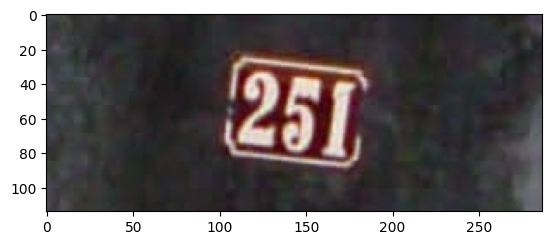

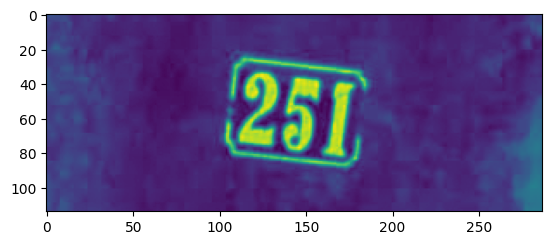

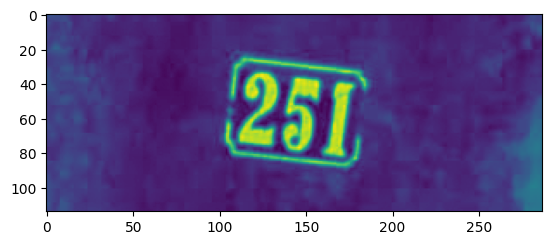

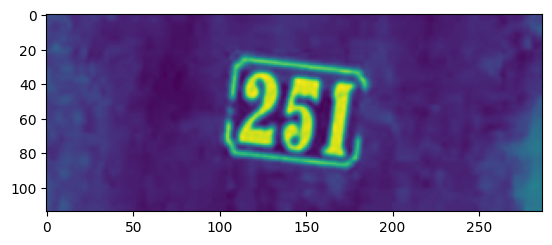

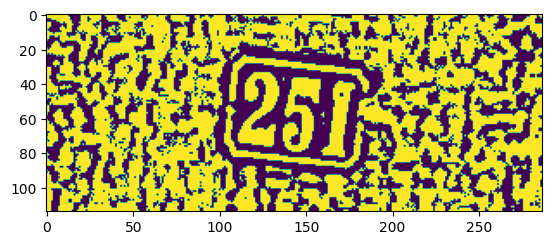

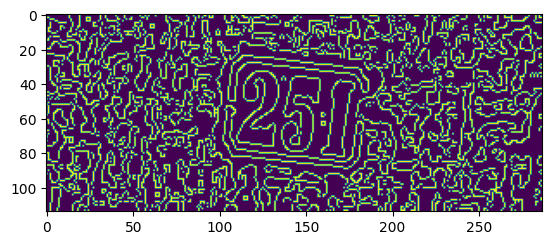

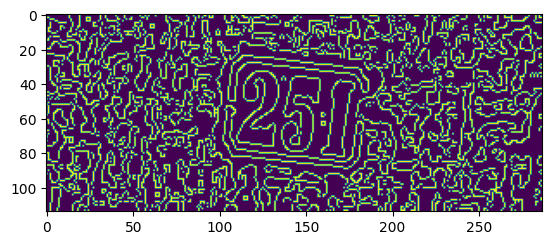

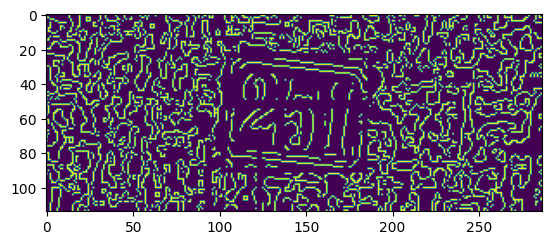

In [26]:
image=images[41].copy()
plt.imshow(image)
plt.show()
boxes = []

#convert the image to greyscale
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(image)
plt.show()

#increase the contrast
cv2.convertScaleAbs(image, image)
plt.imshow(image)
plt.show()

#apply gaussian blur to smooth the image
image = cv2.GaussianBlur(image, (3, 3), 0)
plt.imshow(image)
plt.show()


#apply adaptive threshholding
image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,1)
plt.imshow(image)
plt.show()


#apply canny edge detection
image = cv2.Canny(image, 150, 200, 255)
plt.imshow(image)
plt.show()


#find contours in image
contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
plt.imshow(image)
plt.show()

#get the center of the image
h, w = image.shape
center = (int(w/2), int(h/2))

#calculate the bounding rectangle of each contour and add it to a dictionary, only if it's near the center
for i in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[i])
    if abs((x + w/2) - center[0]) < 1.5*w and abs((y + h/2) - center[1]) < 1.5*h:
        boxes.append({'left': x, 'top': y, 'width': w, 'height': h})

for i in boxes:
     cv2.rectangle(image, (i['left'], i['top']), (i['left'] +
                        i['width'], i['top']+i['height']), (0, 255, 0), 2)

plt.imshow(image)
plt.show()

<h3>Show Images with bounding boxes </h3>

In [ ]:
acc = []
for i in range(0,1000):
    # plt.imshow(images[i])
    # plt.show()
    boxes = draw_boxes(edgeImages[i],imagesCopy[i])
    # tp,precision, recall, f1_score = overlapTest(edgeImages[i],imagesCopy[i])
    acc.append(iouPicTest(true_boxes[i],boxes))
    # print (acc)
    # cv2.imshow('image',imagesCopy[i])
    # cv2.waitKey(0)
print(np.average(acc)*100)
# print(precision)
# print(recall)
# print(f1_score)
# print(tp/len(true_boxes))


3.056151360273361
